In [1]:
from libraries import lib
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from libraries.NeuralStates import *
import time

In [5]:
def set_gradients(sampled_vector: MHNeuralState, N, J, Gamma, model: nn.Sequential): # also only for log(amp), phase
    nn_output_calcs = {}
    def model_to_output(x):
        if x in sampled_vector.nn_output:
            return sampled_vector.nn_output[x]
        if x in nn_output_calcs:
            return nn_output_calcs[x]
        tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
        output = model(tens)[0]
        nn_output_calcs[x] = output
        return output
    def output_to_log(x):
        return x[0] + 1.j * x[1]

    elocs = {}
    re_grad_logs = {}
    im_grad_logs = {}
    params = [p for p in model.parameters()]
    for basis_state in sampled_vector.distribution:
        eloc = 0
        nn_output = sampled_vector.nn_output[basis_state]
        for adjacency in lib.generate_adjacencies(basis_state, N):
            nn_output_prime = model_to_output(adjacency)
            eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(output_to_log(nn_output_prime) - output_to_log(nn_output))
        elocs[basis_state] = eloc.detach()
        
        nn_output[0].backward(retain_graph=True)
        real_grads = [p.grad.clone() for p in params]
        for p in params: p.grad = None
        nn_output[1].backward(retain_graph=True)
        imag_grads = [-p.grad.clone() for p in params]
        re_grad_logs[basis_state] = real_grads
        im_grad_logs[basis_state] = imag_grads

    E_eloc = (sum(sampled_vector.distribution[x] * elocs[x] for x in sampled_vector.distribution) / sampled_vector.samples).real

    for i in range(len(params)):
        E_grad_times_loc = sum((re_grad_logs[x][i] * elocs[x].real - im_grad_logs[x][i] * elocs[x].imag) * \
                               sampled_vector.distribution[x] for x in sampled_vector.distribution) / sampled_vector.samples
        E_grad = sum(re_grad_logs[x][i] * sampled_vector.distribution[x] for x in sampled_vector.distribution) / sampled_vector.samples
        params[i].grad = E_grad_times_loc - E_grad * E_eloc

    return E_eloc

def set_gradients_exact(sampled_vector: MHNeuralState, N, J, Gamma, model: nn.Sequential): # also only for log(amp), phase
    nn_output_calcs = {}
    def model_to_output(x):
        if x in sampled_vector.nn_output:
            return sampled_vector.nn_output[x]
        if x in nn_output_calcs:
            return nn_output_calcs[x]
        tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
        output = model(tens)[0]
        nn_output_calcs[x] = output
        return output
    def output_to_log(x):
        return x[0] + 1.j * x[1]

    elocs = {}
    re_grad_logs = {}
    im_grad_logs = {}
    amp = 0
    params = [p for p in model.parameters()]
    for basis_state in sampled_vector.values:
        eloc = 0
        nn_output = sampled_vector.nn_output[basis_state]
        for adjacency in lib.generate_adjacencies(basis_state, N):
            nn_output_prime = model_to_output(adjacency)
            eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(output_to_log(nn_output_prime) - output_to_log(nn_output))
        elocs[basis_state] = eloc.detach()
        
        nn_output[0].backward(retain_graph=True)
        real_grads = [p.grad.clone() for p in params]
        for p in params: p.grad = None
        nn_output[1].backward(retain_graph=True)
        imag_grads = [-p.grad.clone() for p in params]
        re_grad_logs[basis_state] = real_grads
        im_grad_logs[basis_state] = imag_grads

        amp += abs(sampled_vector.values[basis_state].detach()) ** 2

    E_eloc = (sum(abs(sampled_vector.values[x].detach())** 2 * elocs[x] for x in sampled_vector.values) / amp).real

    for i in range(len(params)):
        E_grad_times_loc = sum((re_grad_logs[x][i] * elocs[x].real - im_grad_logs[x][i] * elocs[x].imag) * \
                                abs(sampled_vector.values[x].detach()) ** 2 for x in sampled_vector.values) / amp
        E_grad = sum(re_grad_logs[x][i] * abs(sampled_vector.values[x].detach()) ** 2 for x in sampled_vector.values) / amp
        params[i].grad = E_grad_times_loc - E_grad * E_eloc

    return E_eloc


In [6]:
def log_amp_phase(nn_output):
    return torch.exp(nn_output[:, 0] + 1.j * nn_output[:, 1])
def bitflip_x(x, N, flips):
    new_x = x
    for _ in range(flips):
        new_x = x ^ (1 << npr.randint(0, N))
    return new_x

In this file we test three methods: (1) simply take grad of <psi|H|psi>, (2) use manual gradient calculation with the list of MH samples, (3) use manual gradient calculation with direct values from the NN as the distribution. Both SGD and Adam optimizer will be used. First we will test for N=6 where excessive basis sates are used, then with N=10, and then N=20, and for each, h=0.1, 1, 10 will be tested. 

In [11]:
methods = ['auto pytorch', 'manual with list', 'manual with values']

In [37]:
# Test for N=6, h=0.1, 128 samples, SGD
N=6; J=1; Gamma=0.1
num_epochs = 200
data_rate = 1
num_samples = 128

true_gse = lib.ground_state_energy(Gamma, N)
print(f'true GSE is: {true_gse}')

models = []
for _ in range(3):
    layers = []
    layers.append(nn.Linear(N, 32))
    for _ in range(2):
        layers.append(nn.Linear(32, 32))
        layers.append(nn.SELU())
    layers.append(nn.Linear(32, 2))
    model = nn.Sequential(*layers)
    models.append(model)
method_energy_data = []
epochs = [n for n in range(num_epochs)]
for i in range(len(methods)):
    method = methods[i]
    model = models[i]
    start = time.time()
    energy_data = []
    print(method)
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
    for epoch in range(num_epochs):
        mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
        optimizer.zero_grad()
        if method == 'auto pytorch': 
            energy = lib.TFIM_expectation_using_locals(mh_state, N, J, Gamma, model, log_amp_phase)
            energy.backward()
        elif method == 'manual with list':
            energy = set_gradients(mh_state, N, J, Gamma, model)
        else:
            energy = set_gradients_exact(mh_state, N, J, Gamma, model)
        optimizer.step()
        if epoch % data_rate == 0:
            energy_data.append(energy.item().real)
        if epoch % 20 == 0:
            print(epoch, energy)
    method_energy_data.append(energy_data)
    print(energy_data[-1])
    print(min(energy_data))
    print(f'method {method} took {time.time() - start} seconds')

true GSE is: -6.0150096436544
auto pytorch
0 tensor(-0.6461, grad_fn=<SelectBackward0>)
20 tensor(-6.0133, grad_fn=<SelectBackward0>)
40 tensor(-6.0148, grad_fn=<SelectBackward0>)
60 tensor(-6.0149, grad_fn=<SelectBackward0>)
80 tensor(-6.0150, grad_fn=<SelectBackward0>)
100 tensor(-6.0151, grad_fn=<SelectBackward0>)
120 tensor(-6.0151, grad_fn=<SelectBackward0>)
140 tensor(-6.0151, grad_fn=<SelectBackward0>)
160 tensor(-6.0151, grad_fn=<SelectBackward0>)
180 tensor(-6.0150, grad_fn=<SelectBackward0>)
-6.01499605178833
-6.015130043029785
method auto pytorch took 2.851905345916748 seconds
manual with list
0 tensor(-0.2783)
20 tensor(-6.0175)
40 tensor(-5.9743)
60 tensor(-6.0091)
80 tensor(-6.0103)
100 tensor(-6.0132)
120 tensor(-6.0130)
140 tensor(-6.0108)
160 tensor(-6.0103)
180 tensor(-6.0103)
-6.010299205780029
-6.545482635498047
method manual with list took 1.707063913345337 seconds
manual with values
0 tensor(-0.5386)
20 tensor(-5.9733)
40 tensor(-6.0089)
60 tensor(-6.0110)
80 tens

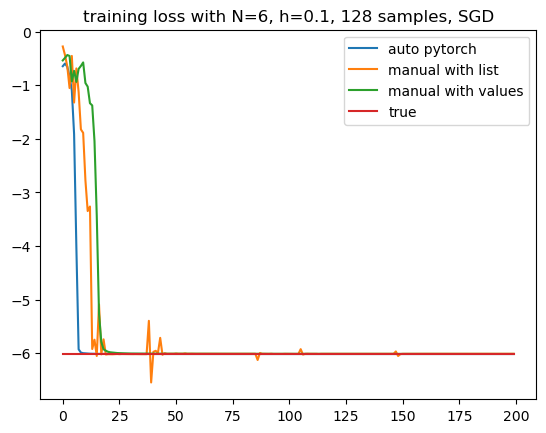

In [38]:
for i in range(len(methods)):
    plt.plot(epochs, method_energy_data[i], label = methods[i])
plt.plot([0, epochs[-1]], 2*[true_gse], label = 'true')
plt.legend(loc='best')
plt.title(f'training loss with N={N}, h={Gamma}, {num_samples} samples, SGD')
plt.show()

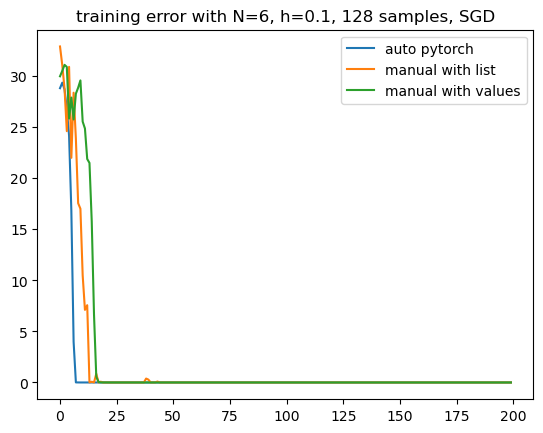

In [39]:
for i in range(len(methods)):
    err = (np.array(method_energy_data[i]) - true_gse) ** 2
    plt.plot(epochs, err, label = methods[i])
plt.legend(loc='best')
plt.title(f'training error with N={N}, h={Gamma}, {num_samples} samples, SGD')
plt.show()

In [43]:
# Test for N=6, h=1, 128 samples, SGD
N=6; J=1; Gamma=1
num_epochs = 200
data_rate = 1
num_samples = 128

true_gse = lib.ground_state_energy(Gamma, N)
print(f'true GSE is: {true_gse}')

models = []
for _ in range(3):
    layers = []
    layers.append(nn.Linear(N, 32))
    for _ in range(2):
        layers.append(nn.Linear(32, 32))
        layers.append(nn.SELU())
    layers.append(nn.Linear(32, 2))
    model = nn.Sequential(*layers)
    models.append(model)
method_energy_data = []
epochs = [n for n in range(num_epochs)]
for i in range(len(methods)):
    method = methods[i]
    model = models[i]
    start = time.time()
    energy_data = []
    print(method)
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
    for epoch in range(num_epochs):
        mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
        optimizer.zero_grad()
        if method == 'auto pytorch': 
            energy = lib.TFIM_expectation_using_locals(mh_state, N, J, Gamma, model, log_amp_phase)
            energy.backward()
        elif method == 'manual with list':
            energy = set_gradients(mh_state, N, J, Gamma, model)
        else:
            energy = set_gradients_exact(mh_state, N, J, Gamma, model)
        optimizer.step()
        if epoch % data_rate == 0:
            energy_data.append(energy.item().real)
        if epoch % 20 == 0:
            print(epoch, energy)
    method_energy_data.append(energy_data)
    print(energy_data[-1])
    print(min(energy_data))
    print(f'method {method} took {time.time() - start} seconds')

true GSE is: -7.727406610312546
auto pytorch
0 tensor(-5.9959, grad_fn=<SelectBackward0>)
20 tensor(-7.5477, grad_fn=<SelectBackward0>)
40 tensor(-7.5186, grad_fn=<SelectBackward0>)
60 tensor(-7.5077, grad_fn=<SelectBackward0>)
80 tensor(-7.5570, grad_fn=<SelectBackward0>)
100 tensor(-7.5221, grad_fn=<SelectBackward0>)
120 tensor(-7.5883, grad_fn=<SelectBackward0>)
140 tensor(-7.5799, grad_fn=<SelectBackward0>)
160 tensor(-7.5670, grad_fn=<SelectBackward0>)
180 tensor(-7.5575, grad_fn=<SelectBackward0>)
-7.590778350830078
-7.650333881378174
method auto pytorch took 5.39006495475769 seconds
manual with list
0 tensor(-5.7934)
20 tensor(-7.8582)
40 tensor(-7.5650)
60 tensor(-7.4895)
80 tensor(-7.4057)
100 tensor(-7.7391)
120 tensor(-7.6101)
140 tensor(-7.5737)
160 tensor(-7.4942)
180 tensor(-7.3910)
-7.542181968688965
-7.912923336029053
method manual with list took 4.769163131713867 seconds
manual with values
0 tensor(-5.9784)
20 tensor(-6.1492)
40 tensor(-6.3074)
60 tensor(-7.5347)
80 te

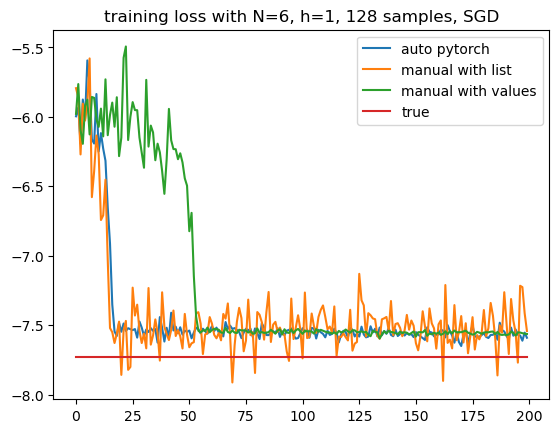

In [44]:
for i in range(len(methods)):
    plt.plot(epochs, method_energy_data[i], label = methods[i])
plt.plot([0, epochs[-1]], 2*[true_gse], label = 'true')
plt.legend(loc='best')
plt.title(f'training loss with N={N}, h={Gamma}, {num_samples} samples, SGD')
plt.show()

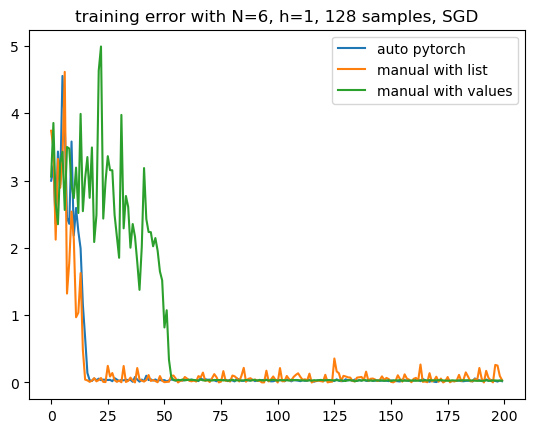

In [45]:
for i in range(len(methods)):
    err = (np.array(method_energy_data[i]) - true_gse) ** 2
    plt.plot(epochs, err, label = methods[i])
plt.legend(loc='best')
plt.title(f'training error with N={N}, h={Gamma}, {num_samples} samples, SGD')
plt.show()

In [48]:
# Test for N=10, h=1, 256 samples, SGD
N=10; J=1; Gamma=1
num_epochs = 200
data_rate = 1
num_samples = 256

true_gse = lib.ground_state_energy(Gamma, N)
print(f'true GSE is: {true_gse}')

models = []
for _ in range(3):
    layers = []
    layers.append(nn.Linear(N, 32))
    for _ in range(2):
        layers.append(nn.Linear(32, 32))
        layers.append(nn.SELU())
    layers.append(nn.Linear(32, 2))
    model = nn.Sequential(*layers)
    models.append(model)
method_energy_data = []
epochs = [n for n in range(num_epochs)]
for i in range(len(methods)):
    method = methods[i]
    model = models[i]
    start = time.time()
    energy_data = []
    print(method)
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
    for epoch in range(num_epochs):
        mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
        optimizer.zero_grad()
        if method == 'auto pytorch': 
            energy = lib.TFIM_expectation_using_locals(mh_state, N, J, Gamma, model, log_amp_phase)
            energy.backward()
        elif method == 'manual with list':
            energy = set_gradients(mh_state, N, J, Gamma, model)
        else:
            energy = set_gradients_exact(mh_state, N, J, Gamma, model)
        optimizer.step()
        if epoch % data_rate == 0:
            energy_data.append(energy.item().real)
        if epoch % 20 == 0:
            print(epoch, energy)
    method_energy_data.append(energy_data)
    print(energy_data[-1])
    print(min(energy_data))
    print(f'method {method} took {time.time() - start} seconds')

true GSE is: -12.784906442999326
auto pytorch
0 tensor(-9.6033, grad_fn=<SelectBackward0>)
20 tensor(-12.5245, grad_fn=<SelectBackward0>)
40 tensor(-12.7497, grad_fn=<SelectBackward0>)
60 tensor(-12.7378, grad_fn=<SelectBackward0>)
80 tensor(-12.4905, grad_fn=<SelectBackward0>)
100 tensor(-12.7487, grad_fn=<SelectBackward0>)
120 tensor(-12.6166, grad_fn=<SelectBackward0>)
140 tensor(-12.5368, grad_fn=<SelectBackward0>)
160 tensor(-12.6885, grad_fn=<SelectBackward0>)
180 tensor(-12.6605, grad_fn=<SelectBackward0>)
-12.435425758361816
-12.896100997924805
method auto pytorch took 41.26809096336365 seconds
manual with list
0 tensor(-9.4395)
20 tensor(-10.1462)
40 tensor(-10.5965)
60 tensor(-11.0866)
80 tensor(-12.3036)
100 tensor(-12.2348)
120 tensor(-12.3164)
140 tensor(-12.5713)
160 tensor(-12.4341)
180 tensor(-12.7026)
-12.640192031860352
-12.980538368225098
method manual with list took 24.708548069000244 seconds
manual with values
0 tensor(-9.9313)
20 tensor(-10.2952)
40 tensor(-11.673

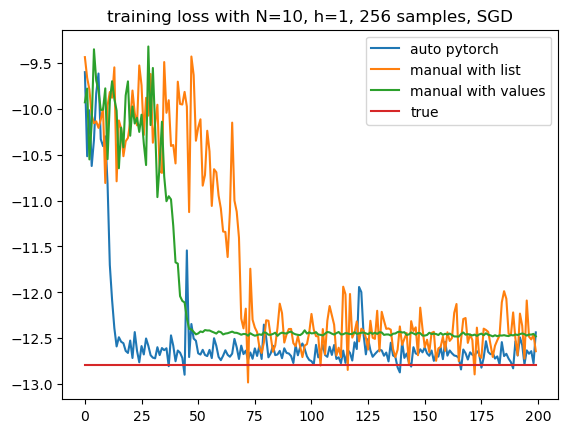

In [49]:
for i in range(len(methods)):
    plt.plot(epochs, method_energy_data[i], label = methods[i])
plt.plot([0, epochs[-1]], 2*[true_gse], label = 'true')
plt.legend(loc='best')
plt.title(f'training loss with N={N}, h={Gamma}, {num_samples} samples, SGD')
plt.show()

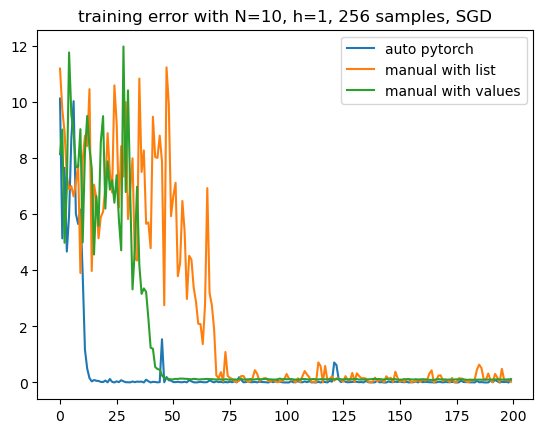

In [50]:
for i in range(len(methods)):
    err = (np.array(method_energy_data[i]) - true_gse) ** 2
    plt.plot(epochs, err, label = methods[i])
plt.legend(loc='best')
plt.title(f'training error with N={N}, h={Gamma}, {num_samples} samples, SGD')
plt.show()

In [51]:
# Test for N=10, h=10, 256 samples, SGD
N=10; J=1; Gamma=10
num_epochs = 200
data_rate = 1
num_samples = 256

true_gse = lib.ground_state_energy(Gamma, N)
print(f'true GSE is: {true_gse}')

models = []
for _ in range(3):
    layers = []
    layers.append(nn.Linear(N, 32))
    for _ in range(2):
        layers.append(nn.Linear(32, 32))
        layers.append(nn.SELU())
    layers.append(nn.Linear(32, 2))
    model = nn.Sequential(*layers)
    models.append(model)
method_energy_data = []
epochs = [n for n in range(num_epochs)]
for i in range(len(methods)):
    method = methods[i]
    model = models[i]
    start = time.time()
    energy_data = []
    print(method)
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
    for epoch in range(num_epochs):
        mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
        optimizer.zero_grad()
        if method == 'auto pytorch': 
            energy = lib.TFIM_expectation_using_locals(mh_state, N, J, Gamma, model, log_amp_phase)
            energy.backward()
        elif method == 'manual with list':
            energy = set_gradients(mh_state, N, J, Gamma, model)
        else:
            energy = set_gradients_exact(mh_state, N, J, Gamma, model)
        optimizer.step()
        if epoch % data_rate == 0:
            energy_data.append(energy.item().real)
        if epoch % 20 == 0:
            print(epoch, energy)
    method_energy_data.append(energy_data)
    print(energy_data[-1])
    print(min(energy_data))
    print(f'method {method} took {time.time() - start} seconds')

true GSE is: -100.25015664234306
auto pytorch
0 tensor(-100.3206, grad_fn=<SelectBackward0>)
20 tensor(-99.9389, grad_fn=<SelectBackward0>)
40 tensor(-100.1379, grad_fn=<SelectBackward0>)
60 tensor(-99.9296, grad_fn=<SelectBackward0>)
80 tensor(-100.2837, grad_fn=<SelectBackward0>)
100 tensor(-100.3257, grad_fn=<SelectBackward0>)
120 tensor(-99.9404, grad_fn=<SelectBackward0>)
140 tensor(-100.2376, grad_fn=<SelectBackward0>)
160 tensor(-100.3203, grad_fn=<SelectBackward0>)
180 tensor(-100.1740, grad_fn=<SelectBackward0>)
-99.90482330322266
-100.9133529663086
method auto pytorch took 66.49017286300659 seconds
manual with list
0 tensor(-99.6784)
20 tensor(-99.7592)
40 tensor(-99.4183)
60 tensor(-100.1504)
80 tensor(-100.0108)
100 tensor(-100.5321)
120 tensor(-100.2499)
140 tensor(-100.1829)
160 tensor(-99.8092)
180 tensor(-99.9151)
-100.5291519165039
-101.06219482421875
method manual with list took 63.696775913238525 seconds
manual with values
0 tensor(-99.7413)
20 tensor(-100.0458)
40 t

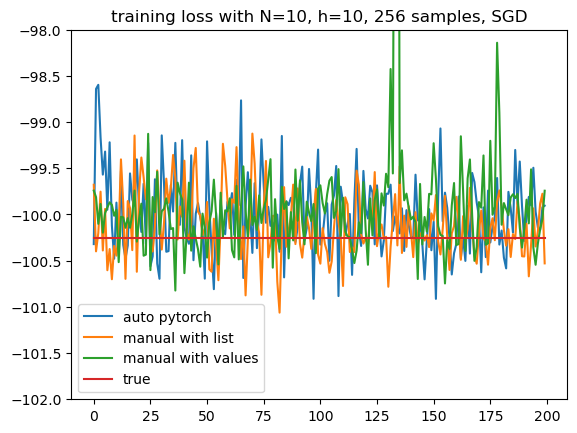

In [54]:
for i in range(len(methods)):
    plt.plot(epochs, method_energy_data[i], label = methods[i])
plt.plot([0, epochs[-1]], 2*[true_gse], label = 'true')
plt.legend(loc='best')
plt.title(f'training loss with N={N}, h={Gamma}, {num_samples} samples, SGD')
plt.ylim(-102, -98)
plt.show()

auto pytorch avg: 0.09893577425511843
manual with list avg: 0.04508773907033492
manual with values avg: 0.08537440178159414


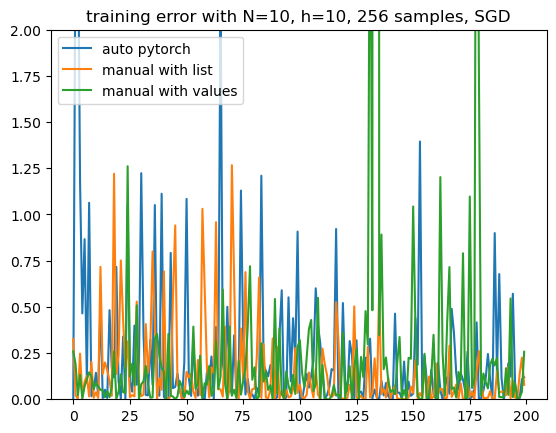

In [60]:
for i in range(len(methods)):
    err = (np.array(method_energy_data[i]) - true_gse) ** 2
    print(f'{methods[i]} avg: {np.median(np.array(err))}')
    plt.plot(epochs, err, label = methods[i])
plt.legend(loc='best')
plt.title(f'training error with N={N}, h={Gamma}, {num_samples} samples, SGD')
plt.ylim(0, 2)
plt.show()

In [ ]:
# loops through all tests
n_values = [6, 10, 20]; J = 1; h_values = [0.1, 1, 10]
methods = ['auto pytorch', 'manual with list', 'manual with values']
optimizers = ['Adam', 'SGD']
N=10; J=1; Gamma=1
num_epochs = 300
data_rate = 1
num_samples = 256

true_gse = lib.ground_state_energy(Gamma, N)
print(f'true GSE is: {true_gse}')

models = []
for _ in range(3):
    layers = []
    layers.append(nn.Linear(N, 32))
    for _ in range(2):
        layers.append(nn.Linear(32, 32))
        layers.append(nn.SELU())
    layers.append(nn.Linear(32, 2))
    model = nn.Sequential(*layers)
    models.append(model)
method_energy_data = []
epochs = [n for n in range(num_epochs)]
for i in range(len(methods)):
    method = methods[i]
    model = models[i]
    start = time.time()
    energy_data = []
    print(method)
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
    for epoch in range(num_epochs):
        mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
        optimizer.zero_grad()
        if method == 'auto pytorch': 
            energy = lib.TFIM_expectation_using_locals(mh_state, N, J, Gamma, model, log_amp_phase)
            energy.backward()
        elif method == 'manual with list':
            energy = set_gradients(mh_state, N, J, Gamma, model)
        else:
            energy = set_gradients_exact(mh_state, N, J, Gamma, model)
        optimizer.step()
        if epoch % data_rate == 0:
            energy_data.append(energy.item().real)
        if epoch % 20 == 0:
            print(epoch, energy)
    method_energy_data.append(energy_data)
    print(energy_data[-1])
    print(min(energy_data))
    print(f'method {method} took {time.time() - start} seconds')